In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1

def sharpe_ratio(daily_ret: np.ndarray) -> float:
    if daily_ret.std() == 0:
        return np.nan
    return np.sqrt(252) * daily_ret.mean() / daily_ret.std()

def max_drawdown(equity: np.ndarray) -> float:
    peak = np.maximum.accumulate(equity)
    drawdown = equity / peak - 1.0
    return drawdown.min()


In [2]:
spy = pd.read_parquet("../data/processed/spy_daily.parquet")
spy["date"] = pd.to_datetime(spy["date"])
spy["year"] = spy["date"].dt.year

spy.head()


,date,adj_close,close,volume,year
0,2010-01-04,85.279190,113.330002,118944600,2010
1,2010-01-05,85.504951,113.629997,111579900,2010
2,2010-01-06,85.565163,113.709999,116074400,2010
3,2010-01-07,85.926361,114.190002,131091100,2010
4,2010-01-08,86.212273,114.570000,126402800,2010


In [3]:
results = []
daily_all = []

years = sorted(spy["year"].unique())

for test_year in years:
    train = spy[spy["year"] < test_year]
    test = spy[spy["year"] == test_year]

    # Skip early years with insufficient training data
    if len(train) < 500 or len(test) == 0:
        continue

    out = run_trend_strategy_v1(
        test,
        train_df=train,
        prediction_threshold=0.0,
        hold_days=5,
        cost_per_side_bps=5.0,
    )

    equity = (1 + out["raw_ret"]).cumprod().values

    summary = {
        "year": test_year,
        "sharpe": sharpe_ratio(out["raw_ret"].values),
        "total_return": equity[-1] - 1.0,
        "max_drawdown": max_drawdown(equity),
        "days_in_market": (out["position"] > 0).mean(),
    }

    results.append(summary)
    daily_all.append(out.assign(year=test_year))


In [4]:
# Results summary
trend_summary = pd.DataFrame(results)
trend_summary


,year,sharpe,total_return,max_drawdown,days_in_market
0,2012,1.392532,0.132940,-0.072339,0.580000
1,2013,1.500693,0.136064,-0.054574,0.710317
2,2014,1.173436,0.095663,-0.054263,0.674603
3,2015,-0.566105,-0.056897,-0.128867,0.615079
4,2016,0.761891,0.061220,-0.061461,0.642857
5,2017,2.812681,0.177062,-0.024545,0.792829
6,2018,-0.657310,-0.070550,-0.117699,0.557769
7,2019,1.179195,0.097973,-0.076268,0.650794
8,2020,1.797851,0.252593,-0.083435,0.525692
9,2021,1.167703,0.119105,-0.048046,0.761905


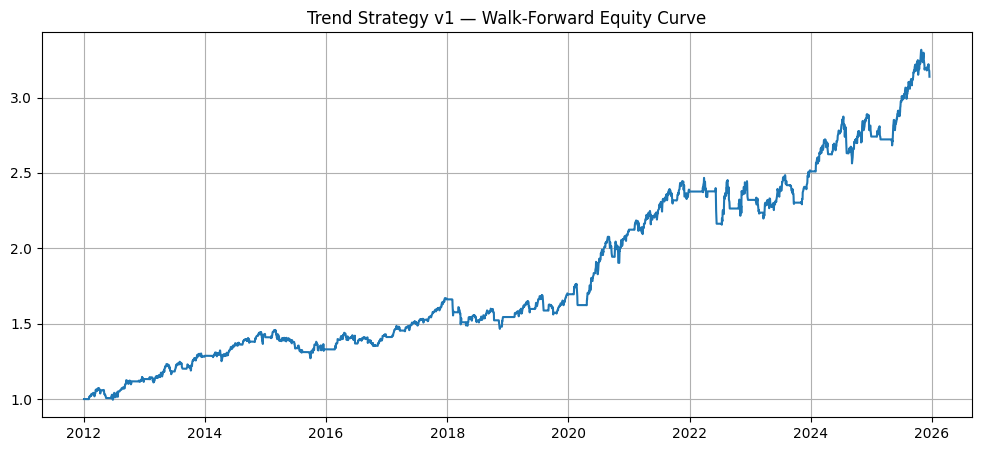

In [5]:
# Equity curve (full period)
trend_daily = pd.concat(daily_all).sort_values("date")
equity = (1 + trend_daily["raw_ret"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(trend_daily["date"], equity)
plt.title("Trend Strategy v1 — Walk-Forward Equity Curve")
plt.grid(True)
plt.show()
